In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ..
%cd /content/drive/MyDrive/Colab Notebooks

!pwd
!ls


Mounted at /content/drive
/
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks
 50608557_50596117_50592389_50593975_phase_1.ipynb	  fall24_cse574_Assignment_0.ipynb
'50608557_50596117_50592389_50593975_phase_2 (1).ipynb'   srayanna_assignment_2_part_3.ipynb
 50608557_50596117_50592389_50593975_phase_2.ipynb	  srayanna_assignment_2_part_4.ipynb
 Assignment_1_group_99.ipynb				  Tree_Inventory_chngd.csv
 DIC_phase_2_copy.ipynb					  Untitled
 DIC_project_p1.ipynb					  Untitled0.ipynb
 fall24_Assign_1_99.ipynb				 'Untitled (1)'
'fall24_cse574_Assignment_0 (1).ipynb'			  Untitled1.ipynb
'fall24_cse574_Assignment_0 (2).ipynb'


In [2]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Tree_Inventory_chngd.csv"

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [4]:
#creating a spark session
spark = SparkSession.builder \
    .appName("UrbanTreePlanting") \
    .getOrCreate()

In [5]:
#feeding the input data from the csv file to spark
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# printing the schema of loaded dataset which are column names and data types
spark_df.printSchema()

root
 |-- Editing: string (nullable = true)
 |-- Botanical Name: string (nullable = true)
 |-- Common Name: string (nullable = true)
 |-- DBH: double (nullable = true)
 |-- Total Yearly Eco Benefits ($): double (nullable = true)
 |-- Stormwater Benefits ($): double (nullable = true)
 |-- Stormwater Gallons Saved: double (nullable = true)
 |-- Greenhouse CO2 Benefits ($): double (nullable = true)
 |-- CO2 Avoided (in lbs.): double (nullable = true)
 |-- CO2 Sequestered (in lbs.): double (nullable = true)
 |-- Energy Benefits ($): double (nullable = true)
 |-- kWh Saved: double (nullable = true)
 |-- Therms Saved: double (nullable = true)
 |-- Air Quality Benefits ($): double (nullable = true)
 |-- Pollutants Saved (in lbs.): double (nullable = true)
 |-- Property Benefits ($): double (nullable = true)
 |-- Leaf Surface Area (in sq. ft.): double (nullable = true)
 |-- Address: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Side: string (nullable = true)
 |-- Site: i

In [8]:
print(spark_df.columns)


['Editing', 'Botanical Name', 'Common Name', 'DBH', 'Total Yearly Eco Benefits ($)', 'Stormwater Benefits ($)', 'Stormwater Gallons Saved', 'Greenhouse CO2 Benefits ($)', 'CO2 Avoided (in lbs.)', 'CO2 Sequestered (in lbs.)', 'Energy Benefits ($)', 'kWh Saved', 'Therms Saved', 'Air Quality Benefits ($)', 'Pollutants Saved (in lbs.)', 'Property Benefits ($)', 'Leaf Surface Area (in sq. ft.)', 'Address', 'Street', 'Side', 'Site', 'Council District', 'Park Name', 'Latitude', 'Longitude', 'Site ID', 'Location26', 'location27']


In [9]:
# we will select the columns which can yield us more valuable insights for the problem statement
selected_columns = [
    "DBH",
    "Total Yearly Eco Benefits ($)",
    "Stormwater Benefits ($)",
    "Energy Benefits ($)",
    "Property Benefits ($)",
    "Greenhouse CO2 Benefits ($)",
    "Latitude",
    "Longitude"
]

In [11]:
spark_df.select(*selected_columns).describe().show()

+-------+------------------+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-------------------+-------------------+
|summary|               DBH|Total Yearly Eco Benefits ($)|Stormwater Benefits ($)|Energy Benefits ($)|Property Benefits ($)|Greenhouse CO2 Benefits ($)|           Latitude|          Longitude|
+-------+------------------+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-------------------+-------------------+
|  count|            133228|                       133228|                 133228|             133228|               133191|                     133228|             133229|             133229|
|   mean| 7.323541222565827|            58.41727144443832|      3.946974584922202| 26.192489191459845|   25.422885630410125|        0.30671187738313754|  42.90885823985526| -78.84676971798305|
| stddev|10.134186394336968|       

In [12]:
spark_df.select(*selected_columns).filter(
    (col("DBH").isNull()) |
    (col("Total Yearly Eco Benefits ($)").isNull()) |
    (col("Stormwater Benefits ($)").isNull()) |
    (col("Energy Benefits ($)").isNull()) |
    (col("Property Benefits ($)").isNull()) |
    (col("Greenhouse CO2 Benefits ($)").isNull()) |
    (col("Latitude").isNull()) |
    (col("Longitude").isNull())
).show()

+----+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-----------+------------+
| DBH|Total Yearly Eco Benefits ($)|Stormwater Benefits ($)|Energy Benefits ($)|Property Benefits ($)|Greenhouse CO2 Benefits ($)|   Latitude|   Longitude|
+----+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-----------+------------+
|NULL|                         NULL|                   NULL|               NULL|                  0.0|                       NULL|42.94612971|-78.83746975|
| 0.0|                          0.0|                    0.0|                0.0|                 NULL|                        0.0|42.92760411|-78.80868909|
| 0.0|                          0.0|                    0.0|                0.0|                 NULL|                        0.0|42.95173734|-78.84902234|
|17.0|                       137.88|                   4.48|    

In [13]:
# mean of all selected columns
mean_dbh = spark_df.filter(col("DBH") > 0).agg(mean("DBH")).first()[0]
mean_eco = spark_df.agg(mean("Total Yearly Eco Benefits ($)")).first()[0]
mean_storm = spark_df.agg(mean("Stormwater Benefits ($)")).first()[0]
mean_energy = spark_df.agg(mean("Energy Benefits ($)")).first()[0]
mean_property = spark_df.agg(mean("Property Benefits ($)")).first()[0]
mean_greenhouse = spark_df.agg(mean("Greenhouse CO2 Benefits ($)")).first()[0]


In [14]:
# replacing invalid or missing values with Mean values
cleaned_df = spark_df.withColumn(
    "DBH", when(col("DBH") > 0, col("DBH")).otherwise(mean_dbh)
).withColumn(
    "Total Yearly Eco Benefits ($)", when(col("Total Yearly Eco Benefits ($)") > 0, col("Total Yearly Eco Benefits ($)")).otherwise(mean_eco)
).withColumn(
    "Stormwater Benefits ($)", when(col("Stormwater Benefits ($)") > 0, col("Stormwater Benefits ($)")).otherwise(mean_storm)
).withColumn(
    "Energy Benefits ($)", when(col("Energy Benefits ($)") > 0, col("Energy Benefits ($)")).otherwise(mean_energy)
).withColumn(
    "Property Benefits ($)", when(col("Property Benefits ($)") > 0, col("Property Benefits ($)")).otherwise(mean_property)
).withColumn(
    "Greenhouse CO2 Benefits ($)", when(col("Greenhouse CO2 Benefits ($)") > 0, col("Greenhouse CO2 Benefits ($)")).otherwise(mean_greenhouse)
)

In [15]:
cleaned_df.select(*selected_columns).describe().show()

+-------+-----------------+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-------------------+-------------------+
|summary|              DBH|Total Yearly Eco Benefits ($)|Stormwater Benefits ($)|Energy Benefits ($)|Property Benefits ($)|Greenhouse CO2 Benefits ($)|           Latitude|          Longitude|
+-------+-----------------+-----------------------------+-----------------------+-------------------+---------------------+---------------------------+-------------------+-------------------+
|  count|           133229|                       133229|                 133229|             133229|               133229|                     133229|             133229|             133229|
|   mean|13.42784253551056|            86.12523455398863|      5.819068633296997| 38.615878821234126|    37.47513744058235|         0.4562957588568181|  42.90885823985526| -78.84676971798305|
| stddev| 7.61530591473877|            5

In [16]:
# uses vectorassembler, feature engineering tool which is a ML library in pyspark that combines multiple input columns into single vector column
assembler = VectorAssembler(
    inputCols=[
        "DBH",
        "Total Yearly Eco Benefits ($)",
        "Stormwater Benefits ($)",
        "Energy Benefits ($)",
        "Property Benefits ($)",
        "Greenhouse CO2 Benefits ($)",
        "Latitude",
        "Longitude"
    ],
    outputCol="features"
)

In [17]:
#performs feature vectorization and standardization
df_vector = assembler.transform(cleaned_df)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

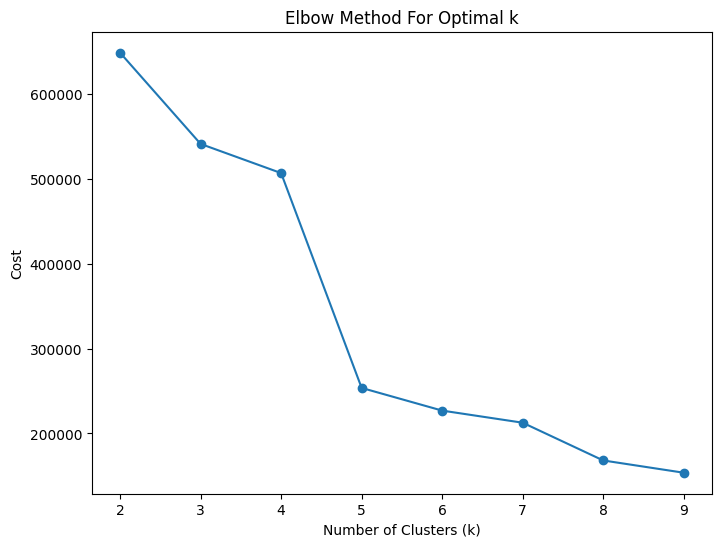

In [18]:
#Implement KMeans Clustering Analysis with Spark MLlib - Algorithm1

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

cost = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(df_scaled)
    cost.append(model.summary.trainingCost)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, cost, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()


In [19]:

optimal_k = 5
kmeans = KMeans(featuresCol='scaledFeatures', k=optimal_k)
model = kmeans.fit(df_scaled)


df_clusters = model.transform(df_scaled)


In [20]:
df_clusters.select("DBH", "Total Yearly Eco Benefits ($)", "Latitude", "Longitude", "prediction").show(10)


+-----------------+-----------------------------+-----------+------------+----------+
|              DBH|Total Yearly Eco Benefits ($)|   Latitude|   Longitude|prediction|
+-----------------+-----------------------------+-----------+------------+----------+
|13.42784253550589|            58.41727144443832|42.94916506|-78.84132058|         0|
|13.42784253550589|            58.41727144443832| 42.9298088| -78.8102528|         0|
|13.42784253550589|            58.41727144443832|42.93403165|-78.81354384|         0|
|13.42784253550589|            58.41727144443832|42.95695596| -78.8357816|         0|
|13.42784253550589|            58.41727144443832|42.94822402|-78.81783686|         0|
|13.42784253550589|            58.41727144443832|42.95575458|-78.82293974|         0|
|13.42784253550589|            58.41727144443832|42.95688523|-78.82363232|         0|
|13.42784253550589|            58.41727144443832|42.95286335| -78.8254994|         0|
|13.42784253550589|            58.41727144443832|42.95

In [22]:
#Implement Regression Analysis with Spark MLlib - Algorithm2

# Select features and label
# performing feature engineering here
assembler = VectorAssembler(
    inputCols=["DBH", "Stormwater Benefits ($)", "Greenhouse CO2 Benefits ($)"],
    outputCol="features"
)
df_regression = assembler.transform(cleaned_df).select("features", col("Total Yearly Eco Benefits ($)").alias("label"))


In [23]:
# train and test split performance
train_data, test_data = df_regression.randomSplit([0.8, 0.2], seed=42)


In [24]:
# Linear regression model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(train_data)

# Evaluate the model
training_summary = lr_model.summary
print("R^2 on training data: ", training_summary.r2)


R^2 on training data:  0.7201567253984525


In [25]:
# model predictions
predictions = lr_model.transform(test_data)
predictions.select("features", "label", "prediction").show(5)


+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|[1.0,0.03,0.30671...| 4.57|34.921455549601376|
|[1.0,0.03,0.30671...|27.82|34.921455549601376|
|[1.0,0.04,0.30671...|  4.7| 34.97183431265176|
|[1.0,0.05,0.30671...|16.99| 35.02221307570213|
|[1.0,0.05,0.30671...|31.06| 35.02221307570213|
+--------------------+-----+------------------+
only showing top 5 rows



In [27]:
#Evaluate Model Performance

from pyspark.ml.evaluation import RegressionEvaluator

# Mean Absolute Error (MAE): Measures the average absolute difference between predicted and actual values (lower is better)
mae_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = mae_evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) = %g" % mae)

# R² Score: Indicates how well the model explains the variance in the data (higher is better, range 0<=R^2<=1).
r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print("R² Score = %g" % r2)



Mean Absolute Error (MAE) = 23.1829
R² Score = 0.730543


In [28]:
#Decision Trees (Classification) - Algorithm3

# Create a label based on EcoBenefits (e.g., High, Medium, Low)
from pyspark.sql.functions import when

df_classification = cleaned_df.withColumn(
    "label",
    when(col("Total Yearly Eco Benefits ($)") >= 100, 2).  # High
    when((col("Total Yearly Eco Benefits ($)") >= 50) & (col("Total Yearly Eco Benefits ($)") < 100), 1).  # Medium
    otherwise(0)  # Low
)

# feature engineernig
assembler = VectorAssembler(
    inputCols=["DBH", "Stormwater Benefits ($)", "Greenhouse CO2 Benefits ($)"],
    outputCol="features"
)
df_classification = assembler.transform(df_classification).select("features", "label")




In [29]:
# train-test split
train_data, test_data = df_classification.randomSplit([0.8, 0.2], seed=42)


In [30]:
# decision tree classification
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')
dt_model = dt.fit(train_data)

predictions = dt_model.transform(test_data)


In [32]:
#Evalutation Metrics for Decision Tree - 1

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = %g " % accuracy)


Test Accuracy = 0.915961 


In [33]:
#Evalutation Metrics for Decision Tree - 2

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision = %g" % precision)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
print("Recall = %g" % recall)

# F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
print("F1-Score = %g" % f1_score)


Precision = 0.923664
Recall = 0.915961
F1-Score = 0.917846


In [34]:
#aggregated eco benefits for each council district using Map Reduce - Algorithm 4


df_clean = cleaned_df.na.drop(subset=["Council District"])


rdd = df_clean.rdd


def map_function(row):
    return (row['Council District'], float(row['Total Yearly Eco Benefits ($)'] or 0))


def reduce_function(a, b):
    return a + b


district_benefits = rdd.map(map_function).reduceByKey(reduce_function).collect()


for district, total_benefit in district_benefits:
    print(f"Council District: {district}, Total Eco Benefits: ${total_benefit:.2f}")


Council District: University, Total Eco Benefits: $926434.67
Council District: Delaware, Total Eco Benefits: $1978581.90
Council District: Fillmore, Total Eco Benefits: $1155794.27
Council District: Lovejoy, Total Eco Benefits: $998682.23
Council District: Masten, Total Eco Benefits: $1259943.88
Council District: Niagara, Total Eco Benefits: $1034537.20
Council District: North, Total Eco Benefits: $974987.70
Council District: Ellicott, Total Eco Benefits: $1491429.72
Council District: South, Total Eco Benefits: $1653987.31


In [35]:
#Enhancing K-Means Clustering - Building Recommendations on Plantations
cluster_data = df_clusters.select("Latitude", "Longitude", "prediction").toPandas()


In [36]:
#Retrieve the centroids:
centroids = model.clusterCenters()
for i, centroid in enumerate(centroids):
    print(f"Cluster {i} Centroid: {centroid}")


Cluster 0 Centroid: [   1.40781955    0.95451429    0.47270104    0.82140349    1.03258819
    0.4302211   351.13461207 -361.58612091]
Cluster 1 Centroid: [1.76327027 0.98341956 0.58746119 0.90399179 0.95823566 0.5183039
 0.         0.        ]
Cluster 2 Centroid: [   3.21464753    3.63072837    2.41305067    3.31029564    3.48734593
    2.15668085  351.11469438 -361.58830435]
Cluster 3 Centroid: [   2.24480489    2.16769075    1.20683119    2.22626802    1.88171623
    1.03157284  351.1747749  -361.60547511]
Cluster 4 Centroid: [   4.4938023     4.55676735    5.27143418    4.25061041    3.30513615
    4.69713023  351.04193615 -361.55880427]


In [37]:
# cluster level analysis
df_clusters.groupBy("prediction").mean(
    "DBH",
    "Total Yearly Eco Benefits ($)",
    "Stormwater Benefits ($)",
    "Energy Benefits ($)",
    "Property Benefits ($)",
    "Greenhouse CO2 Benefits ($)"
).show()


+----------+------------------+----------------------------------+----------------------------+------------------------+--------------------------+--------------------------------+
|prediction|          avg(DBH)|avg(Total Yearly Eco Benefits ($))|avg(Stormwater Benefits ($))|avg(Energy Benefits ($))|avg(Property Benefits ($))|avg(Greenhouse CO2 Benefits ($))|
+----------+------------------+----------------------------------+----------------------------+------------------------+--------------------------+--------------------------------+
|         1| 13.42784253550589|                 58.41727144443832|           3.946974584922202|      26.192489191459845|        25.422885630410125|             0.30671187738313754|
|         3|16.965370245825767|                127.79338630928605|           8.013802369306573|       64.02803808507099|         49.58461701322368|              0.6039433974783674|
|         4| 33.93905036229722|                  270.612252996005|           35.12297736351538|

In [38]:
#Geographical Analysis -  Algorithm 5
import folium
from folium.plugins import MarkerCluster

# Initialize map
map_center = [cluster_data['Latitude'].mean(), cluster_data['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Define custom colors for clusters
cluster_colors = {
    1: "red",         # C1
    4: "orange",      # C4
    3: "blue",        # C3
    2: "lightgreen",  # C2
    0: "darkgreen"    # C0
}

# Add clustered points to the map with specified colors
for idx, row in cluster_data.iterrows():
    cluster_color = cluster_colors[int(row['prediction'])]  # Get the color for the cluster
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=2,
        color=cluster_color,
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# Save the map to an HTML file
m.save('cluster_map.html')


In [39]:
#Methods to Evaluate Clustering - silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator

# Initialize the evaluator
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", metricName="silhouette")

# Calculate silhouette score
silhouette_score = evaluator.evaluate(df_clusters)
print(f"Silhouette Score: {silhouette_score}")



Silhouette Score: 0.664560959657904


In [40]:
# cluster level statistics
df_clusters.groupBy("prediction").mean(
    "DBH", "Total Yearly Eco Benefits ($)", "Stormwater Benefits ($)"
).show()


+----------+------------------+----------------------------------+----------------------------+
|prediction|          avg(DBH)|avg(Total Yearly Eco Benefits ($))|avg(Stormwater Benefits ($))|
+----------+------------------+----------------------------------+----------------------------+
|         1| 13.42784253550589|                 58.41727144443832|           3.946974584922202|
|         3|16.965370245825767|                127.79338630928605|           8.013802369306573|
|         4| 33.93905036229722|                  270.612252996005|           35.12297736351538|
|         2|24.479185468748394|                214.32388114532594|          15.947353862776863|
|         0| 10.70923366753675|                56.511564768750986|           3.174888855197183|
+----------+------------------+----------------------------------+----------------------------+



In [41]:
#Methods to Evaluate Clustering - Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score

# Extract cluster labels and feature data
labels = cluster_data["prediction"].values
data_points = df_scaled.select("scaledFeatures").rdd.map(lambda x: x[0].toArray()).collect()

# Compute Davies-Bouldin Index
db_score = davies_bouldin_score(data_points, labels)
print(f"Davies-Bouldin Index: {db_score}")


Davies-Bouldin Index: 0.9516339104578059


In [42]:
#Methods to Evaluate Clustering - Calinski-Harabasz Index
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(data_points, labels)
print(f"Calinski-Harabasz Index: {ch_score}")


Calinski-Harabasz Index: 106802.46115917468


In [43]:
#Prioritize Areas - Recommendation

# Filter priority clusters
priority_clusters = df_clusters.filter(col("prediction").isin(1, 4))

# Rank areas within priority clusters by low ecological benefits
ranked_areas = priority_clusters.orderBy("Total Yearly Eco Benefits ($)", ascending=True)
ranked_areas.select("Latitude", "Longitude", "Total Yearly Eco Benefits ($)", "DBH").show(10)


+-----------+------------+-----------------------------+-----------------+
|   Latitude|   Longitude|Total Yearly Eco Benefits ($)|              DBH|
+-----------+------------+-----------------------------+-----------------+
|        0.0|         0.0|            58.41727144443832|13.42784253550589|
|42.89132594|-78.80503194|                       103.05|            109.0|
|42.93127368|-78.86640726|                       131.26|            175.0|
|42.96385396|-78.89681367|                       156.48|            125.0|
|42.84741721|-78.80542745|                       156.48|            508.0|
|42.94042026|-78.84724547|                       167.26|             42.0|
|42.91507529|-78.84599062|                       167.26|             42.0|
|42.92030204|-78.87557694|                       167.26|             54.0|
|42.84517761|-78.80236082|                       167.26|             55.0|
|42.91132348|-78.87190383|                       167.26|             43.0|
+-----------+------------

In [44]:
# Define the target benefit and average benefit per tree
target_benefit = 1000
average_benefit_per_tree = 10

# Calculate the number of trees needed
from pyspark.sql.functions import ceil

recommended_areas = ranked_areas.withColumn(
    "Trees Needed",
    ceil((target_benefit - col("Total Yearly Eco Benefits ($)")) / average_benefit_per_tree)
).filter(col("Trees Needed") > 0)

# Show recommendations
recommended_areas.select("Latitude", "Longitude", "Total Yearly Eco Benefits ($)", "Trees Needed").show(10)

# Convert to Pandas for mapping
recommended_areas_pd = recommended_areas.select(
    "Latitude", "Longitude", "Total Yearly Eco Benefits ($)", "Trees Needed"
).toPandas()

+-----------+------------+-----------------------------+------------+
|   Latitude|   Longitude|Total Yearly Eco Benefits ($)|Trees Needed|
+-----------+------------+-----------------------------+------------+
|        0.0|         0.0|            58.41727144443832|          95|
|42.89132594|-78.80503194|                       103.05|          90|
|42.93127368|-78.86640726|                       131.26|          87|
|42.96385396|-78.89681367|                       156.48|          85|
|42.84741721|-78.80542745|                       156.48|          85|
|42.94042026|-78.84724547|                       167.26|          84|
|42.91507529|-78.84599062|                       167.26|          84|
|42.92030204|-78.87557694|                       167.26|          84|
|42.84517761|-78.80236082|                       167.26|          84|
|42.91132348|-78.87190383|                       167.26|          84|
+-----------+------------+-----------------------------+------------+
only showing top 10 

In [45]:
import folium

# Initialize map at the center of all recommendations
map_center = [
    recommended_areas_pd["Latitude"].mean(),
    recommended_areas_pd["Longitude"].mean()
]
m = folium.Map(location=map_center, zoom_start=12)

# Add points to the map
for idx, row in recommended_areas_pd.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=(
            f"<b>Latitude:</b> {row['Latitude']}<br>"
            f"<b>Longitude:</b> {row['Longitude']}<br>"
            f"<b>Total Eco Benefits ($):</b> {row['Total Yearly Eco Benefits ($)']}<br>"
            f"<b>Trees Needed:</b> {row['Trees Needed']}"
        ),
        icon=folium.Icon(color="green", icon="tree")
    ).add_to(m)

# Save and display map
m.save("tree_planting_map.html")
print("Map saved as tree_planting_map.html")


Map saved as tree_planting_map.html


In [46]:
# Display the top 10 recommended areas
print("Top 10 Recommended Areas:")
print(recommended_areas_pd[["Latitude", "Longitude", "Trees Needed"]].head(10))


Top 10 Recommended Areas:
    Latitude  Longitude  Trees Needed
0   0.000000   0.000000            95
1  42.891326 -78.805032            90
2  42.931274 -78.866407            87
3  42.963854 -78.896814            85
4  42.847417 -78.805427            85
5  42.940420 -78.847245            84
6  42.908616 -78.850540            84
7  42.911323 -78.871904            84
8  42.920302 -78.875577            84
9  42.887765 -78.890271            84


In [47]:
#Visualization 1 - Interactive Cluster Heatmap

from folium.plugins import HeatMap

# Prepare data for the heatmap
heat_data = cluster_data[["Latitude", "Longitude"]].values.tolist()

# Add a heatmap layer
heat_map = folium.Map(location=map_center, zoom_start=12)
HeatMap(heat_data).add_to(heat_map)

# Save the heatmap
heat_map.save("cluster_heatmap.html")
print("Heatmap saved as cluster_heatmap.html")





Heatmap saved as cluster_heatmap.html


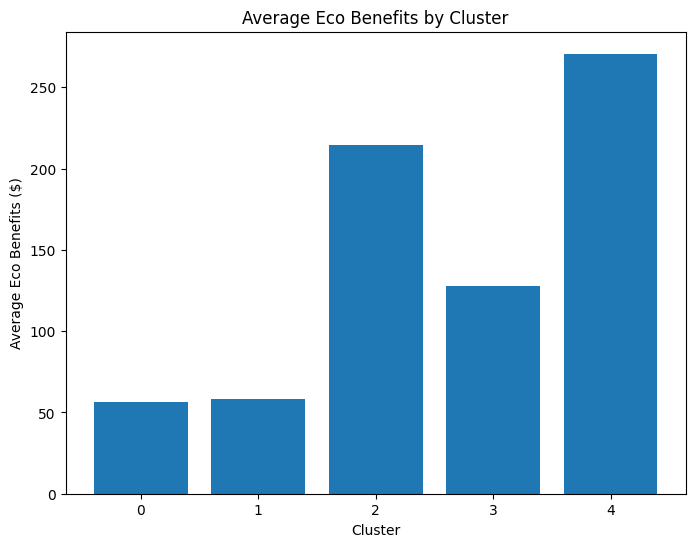

In [48]:
#Visualization 2 - Aggregate average benefits per cluster
avg_benefits = df_clusters.groupBy("prediction").mean(
    "Total Yearly Eco Benefits ($)"
).toPandas()

plt.figure(figsize=(8, 6))
plt.bar(avg_benefits["prediction"], avg_benefits["avg(Total Yearly Eco Benefits ($))"])
plt.title("Average Eco Benefits by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Eco Benefits ($)")
plt.show()


In [49]:
!pip install geopy


In [50]:

top_areas_pd = recommended_areas_pd.sort_values(by="Trees Needed", ascending=False).head(10)


In [51]:
from geopy.geocoders import Nominatim

# Initialize geolocator
geolocator = Nominatim(user_agent="tree_planting_project")

# Function to get location name from latitude and longitude
def get_location(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)
        return location.address
    except:
        return "Unknown Location"


In [52]:
# Add location names to the top 10 areas
top_areas_pd["Location"] = top_areas_pd.apply(
    lambda row: get_location(row["Latitude"], row["Longitude"]),
    axis=1
)

top_areas_pd = top_areas_pd[
    (top_areas_pd["Latitude"] != 0) &
    (top_areas_pd["Longitude"] != 0) &
    (top_areas_pd["Location"] != "Unknown Location")
]


print("Top 10 Recommended Areas:")
print(top_areas_pd)



Top 10 Recommended Areas:
     Latitude  Longitude  Total Yearly Eco Benefits ($)  Trees Needed  \
1   42.891326 -78.805032                         103.05            90   
2   42.931274 -78.866407                         131.26            87   
3   42.963854 -78.896814                         156.48            85   
4   42.847417 -78.805427                         156.48            85   
16  42.832174 -78.826927                         167.26            84   
27  42.874582 -78.800835                         167.48            84   
26  42.908477 -78.878660                         167.48            84   
25  42.930169 -78.872248                         167.47            84   
24  42.840961 -78.803315                         167.47            84   

                                             Location  
1   240, Gold Street, Buffalo, Erie County, New Yo...  
2   Delaware Avenue, Buffalo, Erie County, New Yor...  
3   57, Seabrook Street, Buffalo, Erie County, New...  
4   Cazenovia Parkw

In [53]:
#Visualization  - Plot on Map

import folium

# Initialize map at the center of valid areas
if len(top_areas_pd) > 0:
    map_center = [top_areas_pd["Latitude"].mean(), top_areas_pd["Longitude"].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add markers
    for idx, row in top_areas_pd.iterrows():
        folium.Marker(
            location=[row["Latitude"], row["Longitude"]],
            popup=(
                f"<b>Location:</b> {row['Location']}<br>"
                f"<b>Total Eco Benefits ($):</b> {row['Total Yearly Eco Benefits ($)']}<br>"
                f"<b>Trees Needed:</b> {row['Trees Needed']}"
            ),
            icon=folium.Icon(color="green", icon="tree")
        ).add_to(m)

    # Save the map
    m.save("top_10_tree_planting_map.html")
    print("Map saved as top_10_tree_planting_map.html")
else:
    print("No valid data to plot.")


Map saved as top_10_tree_planting_map.html
